In [ ]:
%pip install dowhy --quiet
import dowhy
import dowhy.datasets
import dowhy.gcm as gcm
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns

from graphviz import Source
from scipy.stats import norm
from sklearn.linear_model import LinearRegression
from sklearn.mixture import GaussianMixture

     |████████████████████████████████| 287 kB 4.2 MB/s 


# Clase 2: Formalismo de redes causales

Hoy veremos cómo usar modelos gráficos para representar nuestras hipótesis causales sobre los datos y operar sobre ellas para identificar efectos causales. En el camino vamos a:

- Distinguir entre red bayesiana y red causal
- Formalizar la diferencia entre flujo de asociación causal y flujo de asociación no causal
- Ver una manera distinta de expresar contrafácticos usando el operador _do_ de Pearl
- Entender qué es un experimento, y por qué es el "estándar de oro" para la identificación causal, usando nuestro nuevo lenguaje.
- Ver algunos formas en las que controlar más variables puede empeorar nuestro sesgo.
- Aprender dos maneras de seleccionar qué variables alcanza controlar para lograr identificación: criterios _backdoor_ ("puerta trasera") y _frontdoor_ ("puerta delantera").

Utilizaremos la librería DoWhy para realizar algunos ejercicios prácticos e ilustrar estas ideas.

Como buscamos que se lleven una idea del poder de este lenguaje, también incluiremos al final una lista de tópicos que nos quedaron afuera del curso por cuestiones de tiempo.

Comenzamos con un pequeño repaso de algunos temas clave de la clase pasada.

----------------


# Repaso

En la clase pasada vimos el marco conceptual de resultados potenciales. Recordemos que

$$Y_i(0) = \text{Resultado que observaría el individuo $i$ si no recibiera el tratamiento}$$
$$Y_i(1) = \text{Resultado que observaría el individuo $i$ si SÍ recibiera el tratamiento}$$

Vimos que el **problema fundamental de la inferencia causal** consiste en el hecho de que no podemos observar tanto $Y(0)$ como $Y(1)$ al mismo tiempo, y que la manera de avanzar contra esta dificultad es encontrar condiciones bajo las cuales correlación y causalidad coinciden (¡O sea que *correlación a veces sí es causalidad*!). A esto lo llamamos **identificación** de efectos causales, y lo distinguimos del paso posterior que consiste en la **estimación** de dichos efectos.

La hipótesis fundamental era lo que llamamos

> **Supuesto de independencia**:
> 
> $$\newcommand{\indep}{\perp \!\!\! \perp}$$
> $$ Y_i(0) \indep T$$
> $$ Y_i(1) \indep T$$

Es decir,

* la probabilidad de que el individuo $i$ obtenga cierto resultado _si se le fuera a administrar el tratamiento_ no cambian al saber si el tratamiento le fue asignado o no.
* la probabilidad de que el individuo $i$ obtenga cierto resultado _si no se le fuera a administrar el tratamiento_ no cambian al saber si el tratamiento le fue asignado o no.

En otras palabras esto codifica un _balanceo de características_: la población que resulta tratada y la que no resulta tratada tienen las mismas características en lo relativo a la obtención de un resultado u otro (un valor u otro de $Y_i$).

Podemos **reformular el supuesto de independencia** como un **supuesto de no confusión**: asumimos que no hay variables confusoras.

_Comentario sobre notación_: de ahora en más usaremos la notación $Y$ para referirnos a la variable $Y_i$ correspondiente a un individuo genérico.

## Caso experimental

En este caso, el diseño nos permite garantizar que no hay variables confusoras. Incluso si antes de aleatorizar el tratamiento hubiera confusores, **al aleatorizar hacemos que esas variables dejen de determinar si alguien recibe o no el tratamiento** y por lo tanto dejan de ser confusoras.

- La forma en que se garantiza el supuesto de independencia es a través de la **asignación aleatoria**: dada la población elegible, esta es asignada aleatoriamente a dos grupos: control y tratamiento.
- Si la muestra es lo suficientemente grande, el grupo tratado y el de control serán similares en sus covariables, gracias a la Ley de los Grandes Números (aunque puede haber fluctuaciones).
  * Podemos chequear el balanceo en covariables _observables_ luego de realizar la asignación.
  * Pero no podemos hacerlo en covariables _inobservables_. De aquí la necesidad de un supuesto de identificación.

El experimento ideal sería poder hacer una asignación aleatoria en dos etapas:
  1. Sortear muestra de elegibles. Asegura validez externa, los elegibles son representativos de la población de interés.
  2. Asignar a tratamiento y control. Asegura validez interna.
Este es el procedimiento que se realiza tanto en los **ensayos aleatorizados controlados** (RCTs en inglés), que se realizan por ejemplo para medir el efecto clínico de tratamientos médicos, como en **A/B testing** (a ver mejor en la Clase 4).

## Caso observacional

En el caso observacional vamos a asumir en general la existencia de variables confusoras. Entonces reemplazamos el supuesto de independencia/no-confusión por el

> **_Supuesto de no-confusión condicional_**:
> 
> $$ Y(0) \indep T \mid W$$
> $$ Y(1) \indep T \mid W$$
> 
> donde $W$ es algún conjunto de variables observadas por el cual vamos a controlar (por ejemplo, que incluiremos como variables regresoras en una regresión lineal). A este conjunto lo llamamos **conjunto de variables de control** o **conjunto de ajuste**.

Esta condición tiene muchos nombres, como _ignorabilidad condicional_, _intercambiabilidad condicional_ o _unconfoundedness_ en inglés.

---
# La fórmula de ajuste

El supuesto de no-confusión condicional implica que si únicamente consideramos a los individuos para los cuales el valor que adopta $W$ es $w$ (recordemos que $W$ puede ser una variable compuesta, es decir una tupla), el efecto causal coincide con la diferencia observada. Matemáticamente, podemos escribir

$$\DeclareMathOperator{\E}{\mathbb{E}}$$
\begin{equation}
  \underbrace{\E[Y(1) - Y(0) \mid W=w]}_{\text{Efecto causal para los casos en que $W=w$}} = \underbrace{\E[Y \mid T = 1, W = w]}_{\substack{\text{Resultado promedio en población} \\ \text{tratada y con $W=w$}}} - \underbrace{\E[Y \mid T = 0, W = w]}_{\substack{\text{Resultado promedio en población} \\ \text{no tratada y con $W=w$}}}. \tag{1}
\end{equation}

Luego, tomando esperanza en $W$ (es decir, promediando sobre todos los valores posibles de $W$) a ambos lados de la ecuación obtenemos la 

> **Fórmula de Ajuste**:
> 
> bajo el supuesto de no-confusión condicional en $W$, el ATE puede calcularse como
> 
> $$\E[Y(1) - Y(0)] = \E_W [ \E[Y \mid T=1, W] - \E[Y \mid T=0, W] ] \tag{2}$$


## Fórmula de ajuste, regresión lineal y estimación asistida por modelos

En la clase pasada estimamos el ATE usando regresión lineal. El caso de un modelo lineal

$$Y = \beta_0 + \beta_1 t + \beta_2 X_1 + \dots + u$$

en el cual la variable $t$ es binaria ("variable _dummy_"), el ATE identificado según la fórmula de ajuste resulta ser exactamente $\beta_1$ (puede hacerse la cuenta analítica). Por eso, bajo la hipótesis de que el modelo fuera correcto, nos alcanzaba con estimar $\beta_1$.

Pero también podamos tomar otro enfoque, que es el de la **estimación asistida por modelos**. En este caso pensamos así:

* Si tengo la función $f(t, w) = \E[Y \mid T=t, W=w]$, o más realísticamente un estimador $\hat{f}$ para esa función, entonces puedo usarla para calcular el ATE con un promedio empírico

$$\frac{1}{n} \sum_i \left( \hat{f}(1, w_i) - \hat{f}(0, w_i) \right) \tag{3}$$
* Entonces _puedo aproximar la función de esperanza condicional $f(t,w)$ con el modelo que más me guste, y con eso después calcular el ATE_.
* Si hacemos esto con la regresión lineal por cuadrados mínimos, nuestro resultado va a coincidir con $\hat{\beta}_1$, el estimador de cuadrados mínimos para $\beta_1$. Por eso podemos pensar en este enfoque como una generalización que nos permite abandonar la regresión lineal (por ejemplo si sospechamos que las relaciones entre variables se alejan muchísimo de la linealidad).
* Veamos que efectivamente estas dos estimaciones del ATE coinciden para el caso en que el modelo es la regresión lineal, usando los datos sintéticos de ejemplo de la clase pasada:

In [ ]:
## ejemplificación numérica del método explicado arriba

np.random.seed(9)

N = 10000
edad = np.random.normal(40, 10, size = N)
cigarrillos = 50 -0.5 * edad + np.random.exponential(scale = 1, size = N)
fumar = np.array([1 if i > np.mean(cigarrillos) else 0 for i in cigarrillos])
salud = 100 - 10 * fumar  - edad + np.random.normal(size = N)

# Como DataFrame
data = pd.DataFrame(np.array([salud, edad, cigarrillos, fumar]).transpose())
data.columns = ['salud', 'edad', 'cigarrillos', 'fumar']
X = data[['edad', 'fumar']]
y = data['salud']

reg = LinearRegression().fit(X, y)

# Estimación asistida por el modelo de regresión (Ecuación 3 arriba)
W = data[['edad']] # dataframe con los valores de nuestro conjunto de ajuste
diferencia_por_individuo = (reg.predict(W.assign(fumar=1))
                           - reg.predict(W.assign(fumar=0)))
ATE_model_assisted = sum(diferencia_por_individuo) / N
print("Estimación asistida por modelo: ATE = ", ATE_model_assisted)

# Estimación via coeficiente beta_1
print("Estimación del ATE por regresión lineal: ATE = beta_1 = ", reg.coef_[1])

Estimación asistida por modelo: ATE =  -9.978120034463194
Estimación del ATE por regresión lineal: ATE = beta_1 =  -9.978120034464464


Otras observaciones:

* La fórmula de ajuste es **no paramétrica**, es decir es correcta independientemente de cualquier modelo paramétrico, con una forma funcional específica para las relaciones entre variables. Lo único que se asume es un patrón de relaciones causales específico (nuestro modelo causal).
* A este método de estimación del ATE se lo llama también **_S-learner_** ("S" por _single_, porque estamos usando un único modelo de aprendizaje automático para asistir nuestra estimación), aunque ese nombre se suele reservar para cuando se busca estimar el _CATE_.

### Breve comentario sobre el CATE

* ATE = _Average Treatment Effect_ = efecto promedio del tratamiento
* CATE = _Conditional Average Treatment Effect_ = efecto promedio del tratamiento _condicional_ a ciertos valores de las covariables. Es el estimando causal principal a la hora de medir la **heterogeneidad del efecto**, es decir, ver cómo el efecto causal varía según el segmento de nuestra población que consideremos. En este caso hay que distinguir entre covariables que controlamos porque queremos saber el efecto _como función de esas covariables_, de las covariables que controlamos simplemente porque nos hacen falta para obtener identificación. **No entraremos más en detalle sobre el CATE y la estimación de efectos heterogéneos**, pero es importante saber que esto existe dado que muchas veces es extremadamente útil.

---
# Objetivos de la clase

## 1. Queremos poder usar diagramas para razonar y elegir qué variables controlar

Un ejemplo que usamos fue el de la pregunta sobre si asistir a un hospital tiene en promedio un efecto positivo en la salud de las personas. En este caso, identificamos como variable confusora al estado de salud previo a la visita al hospital: las personas con peor estado de salud tienden a visitar más los hospitales. En ese caso, podemos dibujar la relación entre las variables de esta manera:


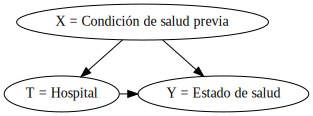

In [ ]:
#@title {display-mode: "form"}
s = 'digraph {\
  T [label="T = Hospital"];\
  Y [label="Y = Estado de salud"];\
  X [label="X = Condición de salud previa"];\
  T -> Y; X -> T; X -> Y;\
  { rank=same; X };\
  { rank=same; T Y };\
  }'
dot = Source(s)
dot


Este fue nuestro primer encuentro con un **grafo causal**.

Un **grafo** se define matemáticamente como un conjunto de nodos o *vértices*, y un conjunto de conexiones o *aristas* entre pares de nodos. En este caso, las aristas son dirigidas, porque **las relaciones causales son asimétricas** (¡a diferencia de las correlaciones!), y las dibujamos como flechas. De un lado tenemos las causas y del otro, los efectos. Más aún, dado que no permitimos que una variable sea causa de sí misma, en estos grafos no es posible partir de un nodo y, siguiendo las direcciones de las flechas, volver al mismo. Es decir que se trata de _grafos dirigidos acíclicos_ (_DAGs_).

En un grafo (o red) causal, los caminos representan **flujos de asociación**:

* $T$ está correlacionada con $Y$, pero _por dos razones diferentes_:
  1. Porque está correlacionada con $X$, que a su vez está correlacionada con $Y$ (patrón de relaciones que determina que $X$ sea variable confusora)
  2. Porque es _causa_ de $Y$
* **las flechas representan causalidad directa**, mientras que **los caminos siguiendo las flechas representan causalidad indirecta**.
* La fuente de asociación (1) es _no causal_, porque sigue un camino en el grafo que no respeta la dirección de las flechas ()
* La fuente de asociación (2) es _causal_, porque sigue un camino en el grafo que respeta la dirección de las flechas (el camino podría involucrar más de una flecha, pero mientras que siempre siga la dirección de las flechas va a ser un camino causal).

La idea entonces es que **al controlar por $X$ _bloqueamos_ el camino no causal de $T$ a $Y$** (lo que se llama un "camino _backdoor_"), **y la única asociación que nos queda es la que fluye por el otro camino, que sí es causal**. Esto lo vamos a formalizar mejor. 

Volviendo a la fórmula de ajuste de arriba, **nuestro objetivo será saber cómo conseguir ese conjunto de ajuste $W$ y eso va a depender de la forma particular que adopta el patrón de relaciones causales, codificado como un grafo.**

## 2. Queremos expresar estimandos causales en el formalismo gráfico

Los estimandos causales se pueden expresar, en vez de con potential outcomes, con la **_notación do_ de Pearl**. En vez de escribir $\E[Y(0)]$, vamos a escribir $\E[Y \mid do(T=0)]$, y en vez de escribir $\E[Y(1)]$, vamos a escribir $\E[Y \mid do(T=1)]$.

Esta notación nos provee una concepción matemática alternativa de los contrafácticos basada en el concepto de **_intervención_**, que está integrada con el formalismo de grafos. La idea es que así como podemos _condicionar_ sobre variables, también podemos _intervenir_ variables. **Las reglas de la "probabilidad intervenida" se suman a las reglas de la probabilidad condicional, ampliando la teoría de probabilidades clásica para poder abordar la causalidad**.

---

# 1. Redes Bayesianas

Primero vamos a estudiar un poco el **uso de grafos para representar correlaciones**. Como venimos diciendo, la causalidad se agrega después como una _capa_ por encima de las correlaciones, distinguiendo entre correlaciones causales y correlaciones no causales.

Una **red bayesiana** puede pensarse como una forma de representar distribuciones conjuntas de múltiples variables. Es decir que es una herramienta de modelización _estadística_, y no causal (ya vamos a retomar la causalidad en la sección siguiente). Empezamos por acá porque mucho de lo que hace a una red causal es "heredado" de las redes bayesianas.

Dada una distribución de probabilidad conjunta $p$ sobre $n$ variables, siempre es posible factorizarla de distintas maneras. Por ejemplo, dado un ordenamiento arbitrario de las variables $X_1, \ldots X_n$, la regla del producto para probabilidades siempre nos permitirá escribir

\begin{equation}\tag{4}
    p(x_1, \ldots x_n) = \prod_{j=1}^n p(x_j | x_1, \ldots x_{j-1}).
\end{equation}

Es importante recalcar que la **Ecuación 4 es válida siempre.** Pero muchas veces podemos elegir **otras factorizaciones más útiles**. Los puntos clave son que

* los conjuntos sobre los que condicionamos pueden ser más pequeños que los de la Ecuación 4.
* No hay una factorización única que sea _la correcta_.

Como ejemplo muy muy sencillo, supongamos que tenemos una distribución conjunta sobre dos variables binarias $X$ e $Y$. Entonces podemos escribir

$$ p(x, y) = p(x \mid y) p(y) = p(y \mid x) p(x). $$

Las dos factorizaciones son válidas, no hay una que sea mejor que la otra. Esto va a cambiar cuando metamos la causalidad en el medio.

Por otro lado, dado un DAG $G$ con $n$ vértices, asociando a cada vértice $j$ una variable aleatoria $X_j$, es posible leerlo como una _propuesta de factorización_. Así, si llamamos $PA_j = (PA_j^{(1)}, \ldots PA_j^{(m)})$ a la variable aleatoria compuesta por los $m$ padres del nodo $j$, el cual corresponde a su vez a la variable aleatoria $X_j$, la propuesta de factorización según $G$ es

\begin{equation}\tag{5}
    p(x_1, \ldots x_n) = \prod_{j=1}^n p(x_j | pa_j)
\end{equation}

donde usamos la notación compacta $p(x_j | pa_j) = p(x_j | PA_j^{(1)} = pa_j^{(1)}, \ldots PA_j^{(m)} = pa_j^{(m)})$. Esta propuesta puede corresponder o no a una factorización válida de $p$. En la jerga de redes bayesianas, si el DAG $G$ da una factorización válida de $p$, decimos que $G$ y $p$ son _Markov-compatibles_.

Por ejemplo para las factorizaciones de una distribución de dos variables, los DAGs correspondientes serían estos:

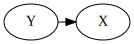

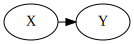

In [ ]:
#@title {display-mode: "form"}
s = 'digraph {Y -> X; { rank=same X Y}}'
t = 'digraph {X -> Y; { rank=same X Y}}'
dot_s = Source(s)
dot_t = Source(t)
display(dot_s)
display(dot_t)

Ahora sí: una **red bayesiana** no es más que un una distribución conjunta $p$ y un DAG $G$ que sea **_minimal_** entre todos los DAGs Markov-compatibles con $p$. Es decir que la factorización no implica condicionar sobre variables innecesarias. Esto es importante porque quiere decir que **todas las flechas que aparecen son "en serio"**: representan dependencias condicionales que realmente están ahí en la distribución.

## Ejemplo 1: la fiebre marciana

Consideremos el ejemplo de la [fiebre marciana](http://reports-archive.adm.cs.cmu.edu/anon/2002/CMU-CS-02-138.pdf) de Scott Davis. Se trata de un ejemplo médico hipotético y ocurrente en el que las personas que visitan Marte ($V=1$) pueden contagiarse la mortal _fiebre marciana_ ($F$), que tiene como principales síntomas la secreción nasal ($R$), el dolor de cabeza ($H$) y la combustión espontánea ($S$). Por otro lado, la secreción nasal y el dolor de cabeza también pueden ser alternativamente producto de un resfrío común ($C$).

Una pregunta vital podría ser cuál es la probabilidad de sufrir combustión espontánea dado que me duele la cabeza, $p(S \mid H=1)$.


![](imgs/martian_death_flu.png)

El DAG de la izquierda representa una distribución conjunta $p(v,c,m,r,h,s)$ y una factorización

$$ p(v,c,f,r,h,s) = p(v) \ p(c) \ p(f \mid v) \ p(r \mid c, f) \ p(h \mid c, f) \ p(s \mid f)$$

mientras que las tablas de probabilidad de la derecha justamente nos dan los valores de las probabilidades condicionales involucradas en esta factorización. A estas funciones de probabilidad condicional que aparecen en la factorización también se las llama _Markov kernels_ o _kernels de Markov_.

Esto es un buen ejemplo de cómo **las redes bayesianas son una forma eficiente de representar distribuciones esparsas**: si escribiéramos la distribución conjunta como una tabla de 6x6, en esa representación tendríamos un montón de información redundante.

Ojo: no es que la tabla de 6x6 esté llena de _ceros_, sino que el resto de los valores se pueden calcular a partir de estos. Por ejemplo, que en la representación de tablas de probabilidad condicional de arriba no tengamos un número para $p(r \mid h)$ no quiere decir que $R$ y $H$ sean independientes. De hecho, si me duele la cabeza aumenta la probabilidad de que tenga secreción nasal.

### Condición de Markov

Una forma alternativa y muy poderosa de decir que $p$ y $G$ son Markov-compatibles es la siguiente:

> **Condición de Markov local**: toda variable es independiente de las demás condicional en el valor de sus variables _padre_.

Una manera alternativa de definir red bayesiana es como una distribución de probabilidad y un DAG tales que se satisface esta condición de Markov (y tal que además se tiene minimalidad). Pero la intuición es diferente: ahora estamos diciendo que **los padres de una variable son la _interfaz_ de esa variable con las demás, en un sentido informacional**. Otra terminología común es que el conjunto de padres de una variable es el _contorno de Markov_ (_Markov boundary_) de la variable.

# Bloqueo y desbloqueo de caminos

Antes de añadir la causalidad a todo esto, es muy útil estudiar distintos patrones que pueden ocurrir dentro de una red bayesiana y qué fenómenos probabilísticos están asociados a esas formas gráficas.

## Cadena

En este ejemplo, las variables $V \to M \to H$ forman una _cadena_: un camino en el que todas las flechas apuntan en la misma dirección. Eso quiere decir que $H$ depende probabilísticamente de $M$ y $M$ depende probabilísticamente de $V$. Por lo tanto, $H$ depende probabilísticamente de $V$. Es decir, _la correlación "fluye" sin impedimentos a través de las cadenas_.

## _Fork_

La variable $C$ junto con sus variables hijas $R$ y $H$ es lo que se denomina una variable _fork_ o _bifurcación_: en este caso tanto $R$ como $H$ están correlacionadas con $C$ y por lo tanto se vuelven correlacionadas entre sí. Esto es lo que mencionábamos más arriba: si me duele la cabeza aumenta la probabilidad de que tenga secreción nasal.

$$p(r, c, h) = p(c) \ p(r \mid c) \ p(h \mid c)$$
$$p(r, h) = \sum_c p(c) \ p(r \mid c) \ p(h \mid c) \neq p(r) \ p(h) $$

## _Colliders_ y la Paradoja de Berkson

Por otro lado, la variable $H$ junto con sus variables padre $C$ y $F$ forma la configuración que llamamos _collider_ o _colisión_. En este caso, las variables padres sí son independientes:

$$p(c, h, f) = p(c) \ p(f) \ p(h \mid c, f)$$
$$p(c, f) = \sum_h p(c, h, f) = p(c) \ p(f)$$

**_Sin embargo al condicionar sobre su hijo en común, dejan de ser independientes_**. Acá nos encontramos con otra de las supuestas "paradojas" de la teoría de probabilidades, conocida como la **Paradoja de Berkson**.

En este ejemplo, la "paradoja" sería la siguiente: si por alguna razón solo miro personas con dolor de cabeza (por ejemplo, porque soy el médico de una institución y la gente viene a verme cuando le duele la cabeza), voy a tener la percepción de que la fiebre marciana está correlacionada negativamente con el resfrío común.

Otro ejemplo, muy común para ejemplificar esta paradoja, es este: supongamos que en una población, el talento actoral no está correlacionado con el atractivo físico. En este caso, si hago un estudio de estas variables _solamente sobre celebridades_, voy a ver una correlación negativa.

![](imgs/berkson.png)

En este caso la explicación del efecto estaría en que las personas que no son ni talentosas ni convencionalmente atractivas no tienden a llegar al status de celebridad y por lo tanto quedan fuera de la población observada. Otros ejemplos similares pueden encontrarse con admisiones a universidades y cosas por el estilo.

## d-Separación

En síntesis, **observando el DAG de una red bayesiana, es posible determinar de manera puramente gráfica qué conjuntos de variables hay que condicionar para hacer que dos variables se vuelvan probabilísticamente independientes**. (No solo eso, sino que también se puede identificar cómo volver independientes dos _conjuntos_ de variables.)

El concepto de teoría de grafos que captura esta noción gráfica de independencia es el de *d-separación*. El resultado fundamental es que **d-separación en el grafo implica independencia condicional entre las variables aleatorias**. Las reglas son:

- la asociación fluye por toda cadena $i \to m \to j$ y todo _fork_ $i \leftarrow m \to j$ tales que el vértice intermedio $m$ no esté condicionado (de lo contrario, se bloquea el camino).
- la asociación _no_ fluye por los _colliders_ $i \to m \leftarrow j$ a menos que el vértice intermedio $m$ o alguno de sus descendientes esté condicionado. En ese caso el camino se desbloquea.

![](imgs/d-separacion.png)

---
## Ejemplo 2: modelo de mezcla de gaussianas (GMM)

Antes de pasar a las redes causales, podemos cerrar el tema de redes bayesianas con un ejemplo más cercano al aprendizaje automático. Este ejemplo es bastante sencillo como DAG pero ilustra muy bien el uso de redes bayesianas como modelos para realizar inferencia estadística.

Los modelos de mezcla de gaussianas o _Gaussian Mixture Models_ (GMMs) se pueden pensar como un método de _clustering_. Pueden usarse para _topic modelling_ (modelado de temas) o por ejemplo para identificar quién está hablando en una grabación de muchas personas. 

![](imgs/gmm.png)

El modelo consiste en este DAG, junto con una especificación paramétrica de las probabilidades involucradas:

* $P(z_i)$ es una distribución de probabilidad categórica.
* $p(x_i \mid z_i)$ es, para cada valor de $z_i$, una distribución normal con parámetros diferentes.

A la derecha se observa la "notación de placas" o _plate notation_, que es equivalente al DAG que está a la izquierda. Como vemos, el DAG de la izquierda y la distribución de probabilidad que se muestra abajo son Markov-compatibles.

La idea es que el proceso generador de los datos observados ($x_1,\dots,x_N$) involucra variables latentes (las $z_i$) que determinan de qué gaussiana se extrae la muestra.

En este caso, la red bayesiana se utiliza para especificar un modelo estadístico paramétrico (los parámetros son las probabilidades de que $Z$ adopte los valores categóricos $c=1,\dots,m$ y los parámetros $\mu_c, \sigma_c$ de cada una de las gaussianas de la mezcla). Dados algunos datos, estimamos los valores de los parámetros y eso nos permite predecir, dados nuevos datos, de qué gaussiana provienen (e.g. de qué fuente proviene ese sonido).

Un ejemplo brutalmente simplista de este procedimiento sería el siguiente:

In [ ]:
# Generación de datos sintéticos
X1 = np.random.normal(loc=2, size=10000)
X2 = np.random.normal(loc=5, size=10000)
X = np.concatenate((X1, X2)).reshape(-1, 1)
# Entrenamiento por algoritmo EM de una GMM con 2 componentes
gm = GaussianMixture(n_components=2, random_state=0)
gm.fit(X)
print("Estimación de las medias de las gaussianas:", gm.means_)
print("Predicción para x=10: ", gm.predict([[10]]))
print("Predicción para x=-3: ", gm.predict([[-3]]))

Estimación de las medias de las gaussianas: [[2.00861683]
 [5.0173209 ]]
Predicción para x=10:  [1]
Predicción para x=-3:  [0]


**Lo importante que se lleven de esto es que _no hay nada causal acá_**. Esto es meramente un modelo estadístico (bayesiano) que ajustamos a nuestros datos con el objetivo de _predecir_. No hay contrafácticos, no hay hipótesis causales, y por lo tanto no hay conclusiones causales.

----
# 2. Redes Causales

Ahora podemos meternos con la causalidad propiamente dicha. Vamos a **empezar a darle sentido causal a algunos caminos y no a otros**.

**Causalidad mediada e inmediata**: en un grafo causal, las flechas representan causalidad *inmediata*, es decir que la influencia de la causa sobre el efecto no está *mediada* por ninguna otra variable. Más precisamente podemos enunciar la

> **Condición de Markov local _causal_**: dadas las causas inmediatas de un cierto efecto, el efecto es _causalmente independiente_ del resto de sus causas.

Otra forma de ver esto es que **cada flecha representa un _mecanismo causal_ específico** de la naturaleza, mientras que los caminos siguiendo las flechas son relaciones causales dadas por una combinación de mecanismos.

Pero aún tenemos que operacionalizar estos conceptos. Vamos a hacer esto de dos maneras: primero como **modelos causales funcionales**, y luego como **redes bayesianas causales**.

# Modelos causales _funcionales_

También conocidos como modelos causales _estructurales_ (o simplemente _modelos estructurales_ o _ecuaciones estructurales_), los modelos causales funcionales consisten en un DAG con nodos $X_j$, que representan nuestras variables de interés, sumado a una _ecuación estructural_  para cada nodo, de la forma

\begin{equation}\tag{6}
X_j := f_j(PA_j, U_j) 
\end{equation}

En esta ecuación:
* $f_j$ es la _función estructural_ (también llamada "mecanismo causal") detrás de la variable $X_j$
* $PA_j$ es el conjunto de variables padre de $X_j$.
* $U_j$ es la **variable de ruido** asociada a $X_j$. Lo que está diciendo la ecuación es que $X_j$ es una función determinística del valor que adoptan sus variables padre y el valor que adopta su variable de ruido.
  * Muchas veces $f_j(PA_j, U_j) = g_j(PA_j) + U_j$, es decir que el ruido es _aditivo_.
  * Es fundamental que **los $U_j$ son todos independientes entre sí** (si no, tendríamos correlaciones que no aparecen en el DAG de partida).
* El símbolo "$:=$" busca denotar que la relación entre el lado izquierdo y el derecho es asimétrica: no es que dos lados resultan ser iguales, sino que _asignamos_ al lado izquierdo el valor en el lado derecho. Se parece más a un $=$ de Python que al $=$ matemático.
* Para las variables que no tienen padres en el DAG (variables raíz), la Ecuación 6 se simplifica a

$$ X_j := f_j(U_j) = U_j \quad \text{ (variable sin padres)}$$

lo que es lo mismo que simplemente asignarles una distribución de probabilidad, al igual que hacíamos con las redes causales bayesianas.

A modo de _plot twist_, en cierto sentido estuvimos usando modelos causales funcionales todo este tiempo cada vez que generamos datos sintéticos.

Por ejemplo, volvamos al ejemplo de la clase pasada y del principio de esta clase:

```
N = 10000
edad = np.random.normal(40, 10, size = N)
cigarrillos = 50 -0.5 * edad + np.random.exponential(scale = 1, size = N)
fumar = np.array([1 if i > np.mean(cigarrillos) else 0 for i in cigarrillos])
salud = 100 - 10 * fumar  - edad + np.random.normal(size = N)
```
Aquí tenemos un modelo causal funcional con
$$X_{edad} = U_{edad}$$
$$X_{cig} := 50 - 0.5 X_{edad} + U_{cig}$$
$$X_{fumar} := \begin{cases}
1 & X_{cig} > \mu_{cig} \\
0 & X_{cig} \leq \mu_{cig} 
\end{cases}$$
$$ X_{salud} := 100 - 10 X_{fumar} - X_{edad} + U_{salud}$$

y las variables de ruido

$$U_{edad} \sim \mathcal{N}(40, 10)$$
$$U_{cig} \sim \text{Exp}(\lambda = 1)$$
$$U_{salud} \sim \mathcal{N}(0, 1).$$

## Intervenciones

En la introducción de la Clase 1 mencionamos que _los vínculos causales son ontológicos, mientras que los probabilísticos son epistémicos_. Es decir que una relación causal no se ve modificada por cambios en nuestro conocimiento de la situación, mientras que una relación probabilística si puede verse modificada. Un ejemplo típico es el de la paradoja de Berkson o _collider bias_ que vimos más arriba: lo que _sé_ sobre si una persona tiene dolor de cabeza afecta el vínculo probabilístico entre estar resfriado y tener la fiebre marciana, pero no puede afectar la relación _causal_ entre esas dos condiciones (en este caso, una relación causal nula: ninguna es causa de la otra).

Sin embargo, puede decirse algo más fuerte aún: las relaciones causales también _son más robustas ante cambios ontológicos_: ante un cambio en la dinámica del mundo real (que podría llegar a requerir un cambio acorde en nuestro modelo), no es razonable esperar que las relaciones probabilísticas de nuestro modelo sigan valiendo, pero sí es más plausible que algunas relaciones causales se mantengan inalteradas.

Esto se sintetiza en el **Principio de modularidad o independencia de los mecanismos causales**, el cual dice informalmente que cuando un mecanismo causal se ve modificado en el mundo real, en principio no se modifican otros mecanismos (a menos que estén siendo modificados en simultáneo).

Para expresar esto formalmente es que se introduce el concepto de **_intervención_**, asociado a la notación _do_ ("hacer" en inglés). Vamos a decir que cuando intervenimos un modelo causal forzando la variable $T$ a adoptar el valor $t$, estamos realizando la intervención $do(T=t)$.

Las intervenciones en modelos funcionales pueden expresarse de una forma muy intuitiva: intervenir la variable $X_j$ en el modelo $M$ consiste en producir un nuevo modelo $M'$ en el cual se **reemplaza la ecuación estructural $f_j$** por
$$X_j := x_0.$$
En este contexto, el supuesto de modularidad es que **todas las demás ecuaciones estructurales quedan tal cual estaban**.

_Comentario al margen_: Se pueden definir intervenciones más complejas en las que en vez de fijar $T$ a una constante, reemplazamos la ecuación estructural por una función diferente. Sin embargo no consideraremos esas intervenciones en esta clase).

Esto es fácil de ver cuando tenemos un código que genera datos sintéticos. En el código de arriba, la intervención $do(X_{fumar} = 1)$ correspondería a reemplazar el código por el siguiente:
```
N = 10000
edad = np.random.normal(40, 10, size = N)
fumar = np.array([1 for _ in range(N)]
salud = 100 - 10 * fumar  - edad + np.random.normal(size = N)
```

Nuestro modelo modificado ahora genera datos distribuidos de otra manera, correspondientes a un mundo en el cual toda nuestra población fuma, _y no cambió nada más_ ("_ceteris paribus_").

Obviamente en la práctica _no conocemos el código fuente de la realidad_, pero lo que nos está diciendo esto es que si tenemos un modelo funcional (lo cual involucra tanto nuestras hipótesis causales como ajustar el modelo a los datos), podemos usarlo para calcular el resultado de realizar intervenciones.

Esto **ilustra la idea fundamental detrás de la inferencia causal basada en grafos causales**:

* el ideal experimental consistiría en poder llevar nuestras intervenciones deseadas a la realidad, por ejemplo en este caso forzando a una población de personas a fumar más allá de sus preferencias previas.
* Como esto no es posible o permisible, formulamos el concepto de intervención en el nivel puramente matemático.
* Con ese concepto puramente matemático, buscamos averiguar bajo qué condiciones una cuenta con los datos observacionales da el mismo resultado que una cuenta con los datos que nos daría nuestro hipotético experimento.

---

# Redes Bayesianas Causales

Los modelos causales funcionales son _concretos_: las $f_j$ pueden pensarse como la representación matemática de los mecanismos causales mismos, y las intervenciones también tienen una interpretación muy clara. Sin embargo, **no hace falta conocer las $f_j$, ni asumir una forma paramétrica particular, para poder usar los modelos causales funcionales como manera de pensar**. Y si no conocemos la forma de estas $f_j$, **lo que nos queda es esencialmente una red bayesiana causal**, y la interpretación de la causalidad íntegramente en términos de lo que se denomina _distribuciones intervencionales_.

Olvidándonos de las ecuaciones estructurales, lo que queda es

* el DAG que teníamos,
* la distribución conjunta $p(x_1, \dots, x_n)$ inducida por las ecuaciones estructurales y las variables de ruido,
* la interpretación causal de las flechas como mecanismos causales específicos y no mediados.

Fijémonos que **a diferencia de las redes bayesianas estándar, ahora hay una factorización de $p$ que es especial**, porque coincide con el DAG causal, **mientras que todas las demás factorizaciones son "de segunda"**: son factorizaciones válidas probabilísticamente pero que no reflejan las relaciones causales que postula el modelo.

## Intervenciones, de nuevo

Algo que no explicitamos todavía es cuáles son las _queries_ o consultas causales (intervencionales) que podemos hacer una vez que tenemos un modelo causal.

* Una vez que hicimos una intervención $do(T=t)$, pasamos de un modelo original $M$ a un modelo modificado $M_{T=t}$, y sobre este nuevo modelo podemos preguntarnos por todas las cosas por las que nos podíamos preguntar antes.
* Cuando nos olvidamos de las ecuaciones estructurales, **lo que nos podemos preguntar son las distintas probabilidades (condicionales, marginales, etc.) que asigna nuestro modelo, antes y después de modificarlo**.

### Notación _do_

* Para las probabilidades en nuestro modelo de base $M$ usamos la notación de siempre:
$$p(x_1), p(x_1, x_2, x_3) p(x_1, x_2 \mid x_3).$$
* **Para las probabilidades en el modelo intervenido $M_{T=t}$ usamos la notación _do_**:
$$p(x_1 \mid do(T=t)), p(x_1, x_2, x_3 \mid do(T=t)), p(x_1, x_2 \mid do(T=t), x_3).$$

Esta notación pone de relieve que **condicionar e intervenir se parecen, pero no son lo mismo**, como podemos ver en este gráfico muy ilustrativo de Brady Neal:


![](imgs/conditioning_vs_intervening_neal.png)

Las distribuciones que tienen un $do$ adentro, es decir las distribuciones calculadas según modelos intervenidos, se denominan _distribuciones intervencionales_. El principio de modularidad se traduce ahora en la idea de que en la distribución conjunta, **solo se modifica el factor $p(t \mid pa(t))$ correspondiente a la variable intervenida**, mientras que los demás quedan inalterados.

Gráficamente, **una intervención consiste en eliminar las flechas causales que entran a $T$**, dado que ahora el valor de $T$ no es determinado endógenamente al modelo sino exógenamente.

Este es un buen momento para retomar el ejemplo de la fiebre marciana. Ahora tenemos el vocabulario para decir que **si bien presentamos el ejemplo como un red bayesiana ordinaria, en verdad es muy intuitivo asignarle un significado causal a las flechas** (¡tan intuitivo que lo hacemos todo el tiempo sin darnos cuenta!)

![](imgs/martian_death_flu.png)

Si declaramos que esto es una red bayesiana _causal_, entonces podemos hacer intervenciones. Por ejemplo, intervenir la variable $F$ haciendo $do(F=f)$ equivale a producir esta nueva red bayesiana:

![](imgs/martian_death_flu_interv_F.png)

En este modelo intervenido, quitamos la flecha $V \to F$ y por lo tanto $V$ no está correlacionada con ninguna otra variable. Este sería el resultado del experimento en el que se infecta a toda la población con la fiebre marciana (¡no intentarlo en casa!)

De esto se deduce una **regla de cómputo de las distribuciones intervencionales** que se conoce como **factorización truncada**: simplemente tomamos la factorización dada por el DAG original, que recordemos era
$$ p(v,c,f,r,h,s) = p(v) \ p(c) \ p(f \mid v) \ p(r \mid c, f) \ p(h \mid c, f) \ p(s \mid f),$$
y omitimos el factor correspondiente a la variable intervenida, dado que esa variable fue fijada:
$$ p(v,c,r,h,s \mid do(F=f)) = p(v) \ p(c) \ p(r \mid c, f) \ p(h \mid c, f) \ p(s \mid f)$$

Entonces podemos decir que **una red bayesiana causal es una red bayesiana cuyas flechas fueron dotadas de interpretación causal, lo cual se operacionaliza a través de la regla de cómputo de distribuciones intervencionales mediante factorización truncada**.


# DoWhy

[DoWhy](https://py-why.github.io/dowhy/v0.8/index.html) es una librería de Python de muy alto nivel que nos permite realizar una cantidad enorme de tareas de inferencia causal. Un aspecto muy interesante es que combina, al igual que este curso, ideas y métodos provenientes tanto del formalismo de resultados potenciales como del formalismo de grafos causales.

Vamos a usar DoWhy en esta clase para dos cosas:
1. Mostrar el poder de las distribuciones intervencionales.
2. Combinar ídentificación y estimación de efectos causales desde una API de alto nivel.

Recientemente (2022) DoWhy [migró a un modelo de gobernanza de código abierto](https://www.microsoft.com/en-us/research/blog/dowhy-evolves-to-independent-pywhy-model-to-help-causal-inference-grow/), lo cual augura el crecimiento y la consolidación de esta librería como herramienta fundamental en el ecosistema de inferencia causal.


## DoWhy para estimación de intervenciones

Si bien la mayor parte de DoWhy está dedicada a la estimación de efectos causales siguiendo el pipeline modelar -> identificar -> estimar (como veremos más abajo), el subpaquete `dowhy.gcm` nos permite plantear una red bayesiana causal, ajustarla a datos y luego usar el modelo ajustado para calcular resultados intervencionales.

(Ojo: a noviembre de 2022, el subpaquete `dowhy.gcm` está en una fase experimental, con lo cual la API puede sufrir cambios no compatibles hacia atrás en el futuro.)

 Veamos un ejemplo en acción. Primero generamos datos sintéticos.

In [ ]:
np.random.seed(0)
data = dowhy.datasets.linear_dataset(beta=10,
        num_common_causes=2,
        num_treatments=1,
        num_samples=10000,
        treatment_is_binary=False, 
        outcome_is_binary=False,
        stddev_treatment_noise=10)
df = data["df"]
df

,W0,W1,v0,y
0,1.076365,2.671272,24.752943,256.331460
1,1.965185,-0.546899,10.869824,112.956969
2,1.047715,0.279022,-3.374464,-30.235517
3,-0.005592,0.840977,2.413962,25.957001
4,0.241671,1.884652,7.401791,78.780275
...,...,...,...,...
9995,0.164595,3.166854,18.613461,193.500195
9996,-0.915370,0.702040,4.893455,47.935934
9997,-0.011370,0.373119,3.070644,31.479804
9998,-0.961304,0.103850,3.393474,31.482867


Extraemos el código fuente del DAG del modelo generador de los datos en formato _dot_ (un lenguaje de descripción de grafos estándar), y lo visualizamos usando `graphviz`. Visualizamos también la distribución conjunta de los datos usando `seaborn`:

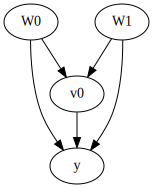

In [ ]:
dot = Source(data['dot_graph'])
dot

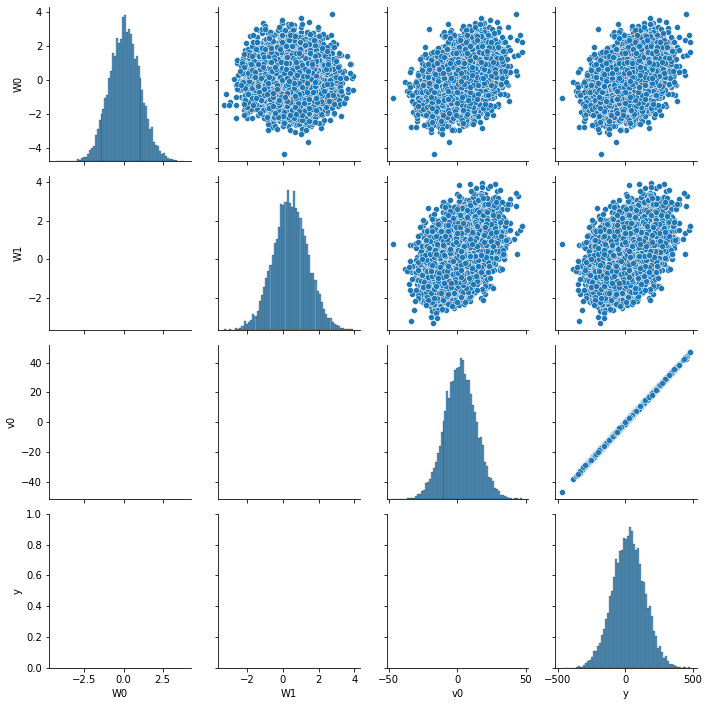

In [ ]:
grid = sns.PairGrid(data["df"])
grid.map_diag(sns.histplot)
grid.map_upper(sns.scatterplot)

Ahora instanciamos la clase `ProbabilisticCausalModel` (que representa redes causales bayesianas), asignándole como DAG subyacente el DAG que _sabemos_ que es el correcto (en la práctica esto no lo sabríamos). También asignamos modelos paramétricos a los nodos que serán ajustados a los datos: una distribución gaussiana para cada nodo raíz y un modelo lineal para los otros dos nodos, con ruido gaussiano en todos los casos. Esto va a funcionar bien porque el dataset _es_ lineal y gaussiano. Luego ajustamos

In [ ]:
# Pasar grafo a objeto nx.DiGraph
g = nx.parse_gml(data['gml_graph'])
# Inicializar red causal bayesiana
causal_model = gcm.ProbabilisticCausalModel(g)
# Asignar modelos paramétricos para los nodos
causal_model.set_causal_mechanism('W0', gcm.ScipyDistribution(norm))
causal_model.set_causal_mechanism('W1', gcm.ScipyDistribution(norm))
causal_model.set_causal_mechanism('v0', gcm.AdditiveNoiseModel(
    prediction_model=gcm.ml.create_linear_regressor(),
    noise_model=gcm.ScipyDistribution(norm)))
causal_model.set_causal_mechanism('y',  gcm.AdditiveNoiseModel(
    prediction_model=gcm.ml.create_linear_regressor(),
    noise_model=gcm.ScipyDistribution(norm)))

In [ ]:
# Ajustar a los datos
gcm.fit(causal_model, data["df"])

Fitting causal mechanism of node v0: 100%|██████████| 4/4 [00:00<00:00, 152.03it/s]


Finalmente, usamos el modelo ya entrenado para producir muestras de la distribución intervencional $p(w1, v0, y \mid do(W0 = 0.16))$, y producimos gráficos con esas muestras para aproximar una visualización de la distribución intervencional. 

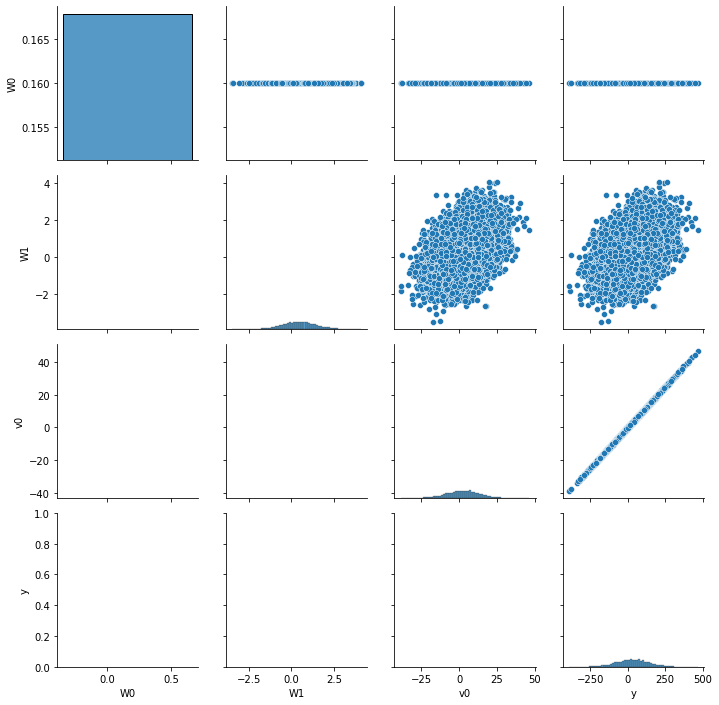

In [ ]:
samples_intervenidos = gcm.interventional_samples(causal_model,
                                                  {'W0': lambda x: 0.16},
                                                  num_samples_to_draw=10000)
grid = sns.PairGrid(samples_intervenidos)
grid.map_diag(sns.histplot)
grid.map_upper(sns.scatterplot)

---
# 3. Métodos de identificación

## Volviendo a los contrafácticos

En el formalismo de grafos causales, **las expresiones contrafácticas son precisamente las que contienen un operador _do_**. En general cualquier probabilidad intervencional $p(X \mid do(Z=z))$ es en sí misma una cantidad causal y por lo tanto, "contrafáctica" en el sentido que venimos usando (aunque Pearl reserva la palabra "contrafáctico" para otra cosa, ver notas del final de la clase). 

Entonces podemos decir que **identificar el efecto causal es eliminar todos los operadores _do_ de nuestra expresión de interés**.

Pero **¿Cuál es nuestra definición del ATE en este formalismo?**

La expresión $p(y \mid do(T=t))$ (o su esperanza $\E[Y \mid do(T=t)]$ no solamente es contrafáctica sino que también la asociación puramente causal entre $T$ e $Y$. Podemos entender esto gráficamente con el ejemplo más sencillo, en el que tenemos un único confusor:

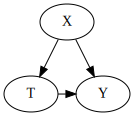

In [ ]:
#@title {display-mode: "form"}
s = 'digraph {\
  T -> Y; X -> T; X -> Y;\
  { rank=same; X };\
  { rank=same; T Y };\
  }'
dot = Source(s)
dot


Al intervenir en $T$, obtenemos el grafo

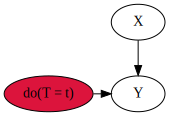

In [ ]:
#@title {display-mode: "form"}
s = 'digraph {\
  T [label="do(T = t)", style=filled, fillcolor=crimson];\
  Y [label="Y"];\
  X [label="X"];\
  T -> Y; X -> Y;\
  { rank=same; X };\
  { rank=same; T Y };\
  }'
dot = Source(s)
dot


Como ahora el único camino entre $T$ e $Y$ respeta la dirección de las flechas, la única asociación presente entre ellos es causal.

Por lo tanto, nuestra definición del ATE va a ser

$$ \text{ATE} = \E[Y \mid do(T=1)] - \E[Y \mid do(T=0)] $$

---
# Ajuste _Backdoor_


**La herramienta más importante** que se van a llevar de esta clase es el método _backdoor_ o de la puerta trasera.

El método deriva su nombre de que llamamos caminos _backdoor_ a los caminos no causales que salen de $T$ a través de alguno de sus padres (salen de $T$ "por la puerta trasera").

> **Criterio _backdoor_**: un conjunto de variables $W$ satisface el criterio _backdoor_ respecto de $T$ e $Y$ si se cumple:
> 1. $W$ bloquea todos los caminos _backdoor_ desde $T$ hacia $Y$
> 2. $W$ no contiene ningún descendiente de $T$ (las llamadas "variables post-tratamiento").

La esencia del método es que bloquear los caminos backdoor produce el mismo efecto que eliminar las flechas entrantes a $T$, porque

* en un caso los caminos _backdoor_ están todos bloqueados, mientras que
* en el otro caso los caminos backdoor no existen.

Es decir que

$$p(y \mid do(T=t), W=w) = p(y | T=t, W=w)$$

Ahora bien, lo que queremos no es esto sino $p(y \mid do(T=t))$, sin condicionar sobre $W$. Para eso tenemos que promediar sobre todos los valores de $W$. Hacer esto con cuidado requiere usar la hipótesis (2) del criterio backdoor, pero en resumidas cuentas, arribamos a la

> **Fórmula de ajuste _backdoor_**: si $W$ cumple el criterio _backdoor_, entonces
> 
> $$ p(y \mid do(t)) = \sum_w p(y \mid t, w) p(w) \tag{7}$$

Esto identifica el efecto causal pues no hay operadores _do_ a la derecha del igual.

## Revisitando la fórmula de ajuste

Recordemos la fórmula de ajuste que vimos al principio de la clase:

$$\E[Y(1) - Y(0)] = \E_W [ \E[Y \mid T=1, W] - \E[Y \mid T=0, W] ] \tag{2}$$

Lo que no sabíamos era cómo elegir $W$ tal que se cumpliera el supuesto de independencia. Ahora sabemos cómo: el supuesto

$$(Y(0), Y(1)) \indep T \mid W$$

es equivalente a que todos los caminos _backdoor_ de $T$ a $Y$ sean bloqueados por $W$, pues entonces se elimina la confusión.

Es decir que alcanza con elegir $W$ tal que satisfaga el criterio _backdoor_. En ese caso la fórmula de ajuste _backdoor_ (Ecuación 7) implica matemáticamente la Ecuación 2.

_Comentario al margen_: En grafos causales, se suele hablar de distribuciones de probabilidad en vez de esperanza. Lo primero es más general, aunque en la práctica muchas veces lo que se termina estimando es lo segundo.

Sin embargo, el criterio _backdoor_ pide algo más que eso: pide que no condicionemos sobre variables que sean descendientes de $T$, las a veces llamadas "variables post-tratamiento". La regla de no condicionar en variables post-tratamiento es común a todos los abordajes a la inferencia causal, incluyendo el marco de Resultados Potenciales.

## ¿Por qué no condicionar en variables post-tratamiento?

Una primera razón, bastante intuitiva, es que podríamos bloquear parte de la asociación causal que estamos intentando medir. Si parte de la influencia de $T$ sobre $Y$ está mediada por otra variable $M$, condicionar en $M$ nos daría un ATE sesgado:

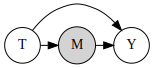

In [ ]:
#@title {display-mode: "form"}
s = 'digraph {\
  T [shape=circle];\
  Y [shape=circle];\
  M [label="M", style=filled, shape=circle];\
  T -> M; M -> Y; T -> Y\
  { rank=same; T M Y };\
  }'
dot = Source(s)
dot


Quizá no haría falta una teoría sofisticada de intervenciones causales para darse cuenta de que esto introduciría un sesgo. Pero existe una segunda razón que tiene que ver con que **podríamos estar generando nuevos caminos no causales**.

![](imgs/condicionar_post.png)

En el DAG de la izquierda, $Z$ es un _collider_ por lo que al condicionar sobre él se abre un camino no causal. En el DAG de la izquierda, condicionar en $Z$ _también_ produce un sesgo. Entender por qué no es tan obvio pero puede ser un buen ejercicio pensarlo.

Como esto se puede poner complicado, incluso si a veces condicionar en variables post-tratamiento puede no inducir sesgo, la mejor regla es simplemente evitarlo, tal como nos dice el criterio _backdoor_.

## M-Bias

Podemos mencionar otro tipo de sesgo que el criterio _backdoor_ evita, que tiene que ver con condicionar sobre un _collider_ pero no en las variables post-tratamiento, sino en las antecesoras del tratamiento. Esto lleva el nombre de "sesgo M" o _M-Bias_ por la forma que tiene el DAG más sencillo en el que se presenta el fenómeno:

![](imgs/mbias.png)

En este caso particular no deberíamos condicionar (conjunto de ajuste vacío), y si lo hacemos abrimos un camino _backdoor_.

Lo importante es que **incluso condicionando únicamente sobre variables pre-tratamiento, podemos inducir sesgo**. **¡No siempre condicionar más variables es mejor!**

## Revisitando los experimentos aleatorizados

Como ya mencionamos antes, los experimentos aleatorizados tienen una serie de características que los convierten en el estándar de oro del análisis causal.

Recordemos que al aleatorizar el tratamiento, se obtiene
1. **Balanceo de características**: por la Ley de los Grandes Números tenderemos a observar que toda covariable $X$ pre-tratamiento aparece igualmente representada en los grupos control y tratamiento (o A y B en A/B testing). Por lo tanto no hay correlación entre el tratamiento y las covariables.
2. **Intercambiabilidad**: los dos grupos son intercambiables, i.e. si hubiéramos asignado al revés, no observaríamos diferencias. Esto implica que $\E[Y(1) \mid T = 1] = \E[Y(1) \mid T = 0]$, y lo mismo para $Y(0)$. Y por eso desaparecía el sesgo al estimar el ATE mediante diferencia de medias.

Ahora estamos en condiciones los experimentos aleatorizados desde una perspectiva más, que es la de los modelos gráficos.

Sencillamente, **cuando $T$ es completamente aleatorio, no depende causalmente de ninguna otra variable, por lo que no tiene padres en el DAG**.Por lo tanto, **no hay caminos _backdoor_**, el conjunto vacío es un conjunto de ajuste válido y $p(y \mid do(T=t)) = p(y \mid t)$.

En otras palabras, **el proceso fáctico de aleatorizar una variable en el mundo real tiene exactamente el mismo resultado en el DAG de dependencias causales que el proceso teórico de aplicar una intervención a esa variable**. Esta es la relación entre las intervenciones y los experimentos.

# Ajuste _Frontdoor_

La principal crítica al método _backdoor_ es bastante obvia: ¿Realmente es creíble suponer que uno conoce todos los confusores posibles, y que además estos son observables? ¿Qué pasa si sabemos o sospechamos que existen confusores que no podemos medir?

El criterio _frontdoor_ (o de la puerta delantera) nos dice que no todo está perdido, pero nuestra esperanza depende de un supuesto bastante delicado.

> **Supuesto de identificación _frontdoor_** ("_Frontdoor Criterion_"): existe un conjunto de variables $M$ tal que
> 1. $M$ es mediador absoluto del efecto de $T$ sobre $Y$ (todos los caminos causales de $T$ a $Y$ son bloqueados por $M$)
> 2. No hay caminos backdoor desbloqueados de $T$ a $M$
> 3. Todos los caminos _backdoor_ de $M$ a $Y$ son bloqueados por $T$.

> **Ajuste _frontdoor_**: bajo el supuesto de identificación _frontdoor_,
> 
> $$ p(y \mid do(t)) = \sum_m p(m \mid t) \sum_{t'} p(y | m, t') p(t') \tag{8}$$

Es decir que $M$ resulta un conjunto de ajuste válido, _incluso aunque no contenga todos los confusores que afectan simultáneamente a $T$ y a $Y$_. Pero ojo: la fórmula de ajuste es diferente.

El ejemplo más sencillo en el que se cumplen las condiciones es el que corresponde a este DAG:

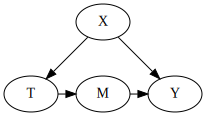

In [ ]:
#@title {display-mode: "form"}
s = 'digraph {\
  X -> T;\
  X -> Y;\
  T -> M;\
  M -> Y;\
  { rank=same; X };\
  { rank=same; T M Y };\
  }'
dot = Source(s)
dot

La intuición, sin entrar en detalle, es que podemos primero identificar el efecto causal de $T$ sobre $M$ (porque no hay confusores para esas dos variables), luego identificar el efecto causal de $M$ sobre $Y$ (porque no hay confusores para esas dos variables una vez que condicionamos en $T$), y luego combinar esos dos efectos causales para deducir el efecto causal de $T$ sobre $Y$.

Esto es bastante distinto al ajuste _backdoor_ dado que estamos condicionando sobre variables "post-tratamiento". Sin tener una teoría matemática sofisticada como esta, habría sido muy difícil (¿imposible?) darnos cuenta de que a veces condicionar sobre variables post-tratamiento puede ser una buena idea.

**Críticas al ajuste _frontdoor_**: se pueden hacer muchas críticas a la credibilidad de una situación como la que muestra el grafo de arriba en el mundo real. Por ejemplo, ¿Cuándo es verdad que _toda_ la influencia del tratamiento es mediada? Si hubiera además una flecha directa de $T$ a $Y$, el método _frontdoor_ no serviría. Además, es necesario que las variables mediadoras no sean afectadas por los confusores inobservados... Puede ser difícil encontrar un ejemplo del mundo real para el que estos supuestos sean creíbles. En las notas al final de la clase dejamos el link a un interesantísimo artículo de Imbens sobre grafos causales en el cual se repasan, entre muchas otras cosas, algunas de estas posibles objeciones.

## DoWhy para estimación de efectos causales

Vamos a cerrar la clase con un ejemplo práctico del método _backdoor_ con DoWhy.

El núcleo de DoWhy consiste en proveer una API que se basa en el mismo _pipeline_ que describimos en la Clase 1: modelar -> identificar -> estimar.

<center>
<img src="https://raw.githubusercontent.com/py-why/dowhy/master/docs/images/dowhy-schematic.png" style="margin:auto" height=300/>
</center>

A diferencia de otras librerías, DoWhy sigue la filosofía de tratar a las hipótesis de modelización como ciudadanos de primera clase. Expresar esas hipótesis es siempre el primero paso, seguido de identificar y luego estimar. En la imagen también se observa un cuarto paso de _refutación_. No entraremos en detalle ahora sobre eso. Podría decirse que este paso consiste en realizar tests estadísticos para poner a prueba la robustez de los resultados obtenidos.

Vamos a concentrarnos en una parte de un Jupyter notebook que provee DoWhy a modo de ejemplo, titulado [La historia causal detrás de las cancelaciones de hoteles](https://github.com/py-why/dowhy/blob/main/docs/source/example_notebooks/DoWhy-The%20Causal%20Story%20Behind%20Hotel%20Booking%20Cancellations.ipynb) (_The Causal Story Behind Hotel Booking Cancellations_). Tener en cuenta que lo que sigue está adaptado a partir de esta fuente.

### Importando los datos

Vamos a importar [los datos de cancelación de hoteles](https://github.com/rfordatascience/tidytuesday/blob/master/data/2020/2020-02-11/readme.md) provenientes de un estudio de [Antonio, Almeida y Nunes (2019)](https://www.sciencedirect.com/science/article/pii/S2352340918315191#f0010) y replicar la selección de _features_ que se realiza en ese notebook (no nos interesa enfocarnos en esto ahora).



In [ ]:
dataset = pd.read_csv('https://raw.githubusercontent.com/Sid-darthvader/DoWhy-The-Causal-Story-Behind-Hotel-Booking-Cancellations/master/hotel_bookings.csv')

In [ ]:
#@title Ingeniería de Features y pre-procesamiento de datos {display-mode: "form"}

# Disabling warnings output
import warnings
from sklearn.exceptions import DataConversionWarning, ConvergenceWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)

# Total stay in nights
dataset['total_stay'] = dataset['stays_in_week_nights']+dataset['stays_in_weekend_nights']
# Total number of guests
dataset['guests'] = dataset['adults']+dataset['children'] +dataset['babies']
# Creating the different_room_assigned feature
dataset['different_room_assigned']=0
slice_indices =dataset['reserved_room_type']!=dataset['assigned_room_type']
dataset.loc[slice_indices,'different_room_assigned']=1
# Deleting older features
dataset = dataset.drop(['stays_in_week_nights','stays_in_weekend_nights','adults','children','babies'
                        ,'reserved_room_type','assigned_room_type'],axis=1)

dataset.isnull().sum() # Country,Agent,Company contain 488,16340,112593 missing entries 
dataset = dataset.drop(['agent','company'],axis=1)
# Replacing missing countries with most freqently occuring countries
dataset['country']= dataset['country'].fillna(dataset['country'].mode()[0])

dataset = dataset.drop(['reservation_status','reservation_status_date','arrival_date_day_of_month'],axis=1)
dataset = dataset.drop(['arrival_date_year'],axis=1)
dataset = dataset.drop(['distribution_channel'], axis=1)

# Replacing 1 by True and 0 by False for the experiment and outcome variables
dataset['different_room_assigned']= dataset['different_room_assigned'].replace(1,True)
dataset['different_room_assigned']= dataset['different_room_assigned'].replace(0,False)
dataset['is_canceled']= dataset['is_canceled'].replace(1,True)
dataset['is_canceled']= dataset['is_canceled'].replace(0,False)
dataset.dropna(inplace=True)

dataset = dataset[dataset.deposit_type=="No Deposit"]

In [ ]:
print(dataset.columns)
dataset.head()

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_month',
       'arrival_date_week_number', 'meal', 'country', 'market_segment',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes', 'deposit_type',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'total_stay', 'guests', 'different_room_assigned'],
      dtype='object')


,hotel,is_canceled,lead_time,arrival_date_month,arrival_date_week_number,meal,country,market_segment,is_repeated_guest,previous_cancellations,...,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,total_stay,guests,different_room_assigned
0,Resort Hotel,False,342,July,27,BB,PRT,Direct,0,0,...,3,No Deposit,0,Transient,0.0,0,0,0,2.0,False
1,Resort Hotel,False,737,July,27,BB,PRT,Direct,0,0,...,4,No Deposit,0,Transient,0.0,0,0,0,2.0,False
2,Resort Hotel,False,7,July,27,BB,GBR,Direct,0,0,...,0,No Deposit,0,Transient,75.0,0,0,1,1.0,True
3,Resort Hotel,False,13,July,27,BB,GBR,Corporate,0,0,...,0,No Deposit,0,Transient,75.0,0,0,1,1.0,False
4,Resort Hotel,False,14,July,27,BB,GBR,Online TA,0,0,...,0,No Deposit,0,Transient,98.0,0,1,2,2.0,False


### Explicitando pregunta e hipótesis causales

La pregunta que nos vamos a hacer es: **¿Cuál es el efecto causal de cambiar de habitación a un cliente en la propensión de ese cliente a cancelar su reserva?**

En base al conocimiento de dominio específico, se propone el siguiente DAG causal que codifica los supuestos causales realizados:

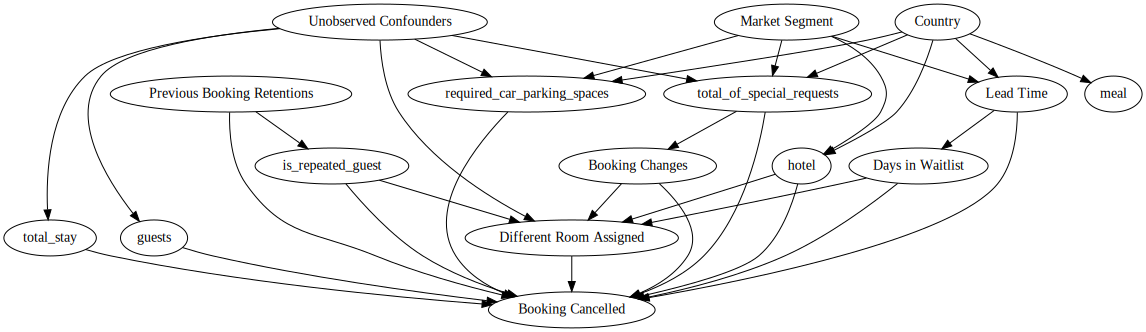

In [ ]:
#@title {display-mode: "form"}
causal_graph = """digraph {
different_room_assigned[label="Different Room Assigned"];
is_canceled[label="Booking Cancelled"];
booking_changes[label="Booking Changes"];
previous_bookings_not_canceled[label="Previous Booking Retentions"];
days_in_waiting_list[label="Days in Waitlist"];
lead_time[label="Lead Time"];
market_segment[label="Market Segment"];
country[label="Country"];
U[label="Unobserved Confounders",observed="no"];
is_repeated_guest;
total_stay;
guests;
meal;
hotel;
U->{different_room_assigned,required_car_parking_spaces,guests,total_stay,total_of_special_requests};
market_segment -> lead_time;
lead_time->is_canceled; country -> lead_time;
different_room_assigned -> is_canceled;
country->meal;
lead_time -> days_in_waiting_list;
days_in_waiting_list ->{is_canceled,different_room_assigned};
previous_bookings_not_canceled -> is_canceled;
previous_bookings_not_canceled -> is_repeated_guest;
is_repeated_guest -> {different_room_assigned,is_canceled};
total_stay -> is_canceled;
guests -> is_canceled;
booking_changes -> different_room_assigned; booking_changes -> is_canceled; 
hotel -> {different_room_assigned,is_canceled};
required_car_parking_spaces -> is_canceled;
total_of_special_requests -> {booking_changes,is_canceled};
country->{hotel, required_car_parking_spaces,total_of_special_requests};
market_segment->{hotel, required_car_parking_spaces,total_of_special_requests};
}"""
dot = Source(causal_graph)
dot

Como puede verse, se incluyó una variable llamada "_Unobserved confounders_" reconociendo que podrían existir confusores inobservados que afecten simultáneamente a ciertas variables (pero no a todas!)

In [ ]:
model= dowhy.CausalModel(
        data = dataset,
        graph=causal_graph.replace("\n", " "),
        treatment="different_room_assigned",
        outcome='is_canceled')

ERROR:dowhy.causal_graph:Error: Pygraphviz cannot be loaded. No module named 'pygraphviz'
Trying pydot ...


### Identificación

In [ ]:
identified_estimand = model.identify_effect()
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
            d                                                                 
──────────────────────────(Expectation(is_canceled|guests,total_of_special_req
d[different_room_assigned]                                                    

                                                                              
uests,booking_changes,days_in_waiting_list,is_repeated_guest,total_stay,hotel,
                                                                              

                                       
lead_time,required_car_parking_spaces))
                                       
Estimand assumption 1, Unconfoundedness: If U→{different_room_assigned} and U→is_canceled then P(is_canceled|different_room_assigned,guests,total_of_special_requests,booking_changes,days_in_waiting_list,is_repeated_guest,total_stay,hotel,lead_time,required_car_parking_spaces,U) = P(is_canceled|different_roo

Acá DoWhy intenta identificar el efecto causal con tres métodos diferentes:

1. _backdoor_. En este caso logra determinar un estimando estadístico que identifica el ATE. La fórmula del estimando a estimar estadísticamente es

$$ \frac{d}{d X_{\text{different_room_assigned}}} \left( \E[X_{\text{is_canceled}} \mid X_{\text{lead_time}}, X_{\text{hotel}}, X_{\text{total_of_special_requests}}, X_{\text{total_stay}}, X_{\text{guests}}, X_{\text{required_car_parking_spaces}}, X_{\text{days_in_waiting_list}}, X_{\text{booking_changes}}, X_{\text{is_repeated_guest}}] \right) $$

En nuestro caso la variable de tratamiento es discreta, no continua (como venimos viendo en todo el curso), con lo que la notación de "derivada" en realidad quiere decir

$$\E[X_{\text{is_canceled}} \mid X_{\text{different_room_assigned}}=1, \ X_{\text{lead_time}}, \dots, X_{\text{is_repeated_guest}}] \\- \E[X_{\text{is_canceled}} \mid X_{\text{different_room_assigned}}=0, \ X_{\text{lead_time}}, \dots, X_{\text{is_repeated_guest}}] $$

que no es más que calcular la diferencia de medias! Es decir que este es nuestro estimando _backdoor_; lo único que falta es usar algún método de estimación para obtener nuestra aproximación del ATE.

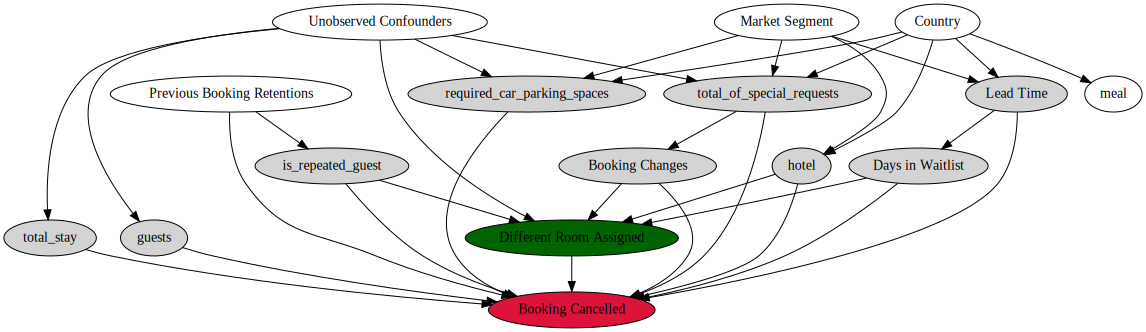

In [ ]:
#@title {display-mode: "form"}
causal_graph_condicionado = """digraph {
different_room_assigned[label="Different Room Assigned", style=filled, fillcolor=darkgreen];
is_canceled[label="Booking Cancelled", style=filled, fillcolor=crimson];
booking_changes[label="Booking Changes", style=filled];
previous_bookings_not_canceled[label="Previous Booking Retentions"];
days_in_waiting_list[label="Days in Waitlist", style=filled];
lead_time[label="Lead Time", style=filled];
market_segment[label="Market Segment"];
country[label="Country"];
U[label="Unobserved Confounders",observed="no"];
is_repeated_guest [style=filled];
total_stay [style=filled];
guests [style=filled];
meal;
hotel [style=filled];
U->{different_room_assigned,required_car_parking_spaces,guests,total_stay,total_of_special_requests};
market_segment -> lead_time;
lead_time->is_canceled; country -> lead_time;
different_room_assigned -> is_canceled;
country->meal;
lead_time -> days_in_waiting_list;
days_in_waiting_list ->{is_canceled,different_room_assigned};
previous_bookings_not_canceled -> is_canceled;
previous_bookings_not_canceled -> is_repeated_guest;
is_repeated_guest -> {different_room_assigned,is_canceled};
total_stay -> is_canceled;
guests -> is_canceled;
booking_changes -> different_room_assigned; booking_changes -> is_canceled; 
hotel -> {different_room_assigned,is_canceled};
required_car_parking_spaces [style=filled];
required_car_parking_spaces -> is_canceled;
total_of_special_requests [style=filled];
total_of_special_requests -> {booking_changes,is_canceled};
country->{hotel, required_car_parking_spaces,total_of_special_requests};
market_segment->{hotel, required_car_parking_spaces,total_of_special_requests};
}"""
dot = Source(causal_graph_condicionado)
dot

2. _frontdoor_. En este caso, DoWhy nos dice que no es posible aplicar el método; ningún conjunto de variables satisface el critario _frontdoor_.

3. **Variables instrumentales**: este método lo veremos en la Clase 3. A diferencia de los métodos de identificación previos, _sí es paramétrico_, y se basa en asumir una relación lineal entre ciertas variables. En este caso, DoWhy nos dice que no es posible aplicar el método incluso si asumiéramos esos supuestos paramétricos dado que no están dadas las condiciones a nivel del DAG causal.

### Estimación

Ahora sí, elegimos un método de estimación y obtenemos un resultado. En el notebook que estamos tomando de referencia se usa un método llamado _Propensity Score Weighting_ que no vamos a cubrir, pero en vez de eso podemos utilizar la regresión lineal con la que al menos ya estamos más familiarizados.

In [ ]:
estimate = model.estimate_effect(identified_estimand, 
                                 method_name="backdoor.linear_regression",
                                 target_units="ate")
print(estimate)
print("Causal Estimate is " + str(estimate.value))

linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['total_stay', 'guests', 'required_car_parking_spaces']}
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
            d                                                                 
──────────────────────────(Expectation(is_canceled|guests,total_of_special_req
d[different_room_assigned]                                                    

                                                                              
uests,booking_changes,days_in_waiting_list,is_repeated_guest,total_stay,hotel,
                                                                              

                                       
lead_time,required_car_parking_spaces))
                                       
Estima

Obtenemos una estimación del ATE de aproximadamente $-0.24$, indicando que reasignarle la habitación a un cliente de hecho _disminuye_ las chances de que cancele la reserva. ¿Es razonable esto? ¿A qué puede deberse?

Como ven, las herramientas formales que presentamos en esta clase son tan solo una parte del arduo trabajo de extraer conclusiones causales a partir de los datos.

# Conclusiones

En esta clase vimos:
- La fórmula de ajuste como síntesis de parte de lo que aprendimos en la Clase 1 con Resultados Potenciales.
- Qué es una red bayesiana
- Distintas formas de asociación entre variables (cadenas, _forks_ y _colliders_), cómo se comportan ante condicionamiento probabilístico y resumimos todo en el concepto de bloqueo de caminos (d-separación).
- La diferencia entre una red bayesiana y una red causal
- Modelos causales funcionales
- Intervenciones ("$do(T=t)$")
  - Eliminación de flechas en el DAG
  - Factorización truncada
- Vimos cómo expresar el ATE en notación _do_
- El _backdoor criterion_ y el _frontdoor criterion_
- La librería DoWhy
  - Respuesta de queries intervencionales a partir de datos (pongo hipótesis causales -> entreno modelo -> respondo preguntas sobre distribuciones intervencionales)
  - Estimación de ATE

Una **idea muy importante** a llevarse de la clase de hoy es que **hay muchas formas de introducir sesgo en nuestra estimación del efecto causal**, y **no siempre es mejor controlar por más variables**. Los criterios _backdoor_ y _frontdoor_ son dos posibles maneras de resolver este problema.

## Cosas que nos quedaron afuera

- **Descubrimiento causal**: para poder imaginar la _automatización del razonamiento causal_, tenemos que imaginar un algoritmo mediante el cual un agente sería capaz de inferir (con un éxito razonable) cuáles son las relaciones causales presentes en un conjunto de variables. Esta tarea se denomina _descubrimiento causal_.
- **_Do-calculus_**: el operador _do_ tiene ciertos axiomas algebraicos asociados. Es como un cálculo de probabilidades extendido con axiomas adicionales. Puede demostrarse que todo efecto causal identificable de forma no paramétrica es identificable a través de la aplicación sucesiva de estos axiomas. Por lo tanto se dice que el _Do-Calculus_ es _completo_ con respecto al problema de identificación causal no paramétrica.
- **Consultas (o _queries_) propiamente contrafácticas**: el tipo de cantidades causales que venimos (y seguiremos) tratando en este curso, como el ATE (ya sea expresado como $\E(Y(1) - Y(0))$, en resultados potenciales, o como $\E[Y \mid do(T = 1)] - \E[Y \mid do(T = 0)]$ en términos de intervenciones), si bien involucran mundos contrafácticos, son en el fondo siempre preguntas _intervencionales_, del estilo "qué pasa si tomo tal decisión" o "qué pasa si fuerzo tal tratamiento en tales pacientes". Pearl distingue estas _consultas (queries) intervencionales_ de un tipo **más difícil** de preguntas, que son las que él llama consultas (propiamente) contrafácticas. Estas consultas son de la forma "¿Qué habría pasado si _no_ se hubiera administrado el tratamiento (dado que sí se administró)?"
  - En Resultados Potenciales, esto se puede pensar como preguntarse por la correlación entre los resultados potenciales $Y(0)$ e $Y(1)$. Por ejemplo si $T=1$ es "me tomo una aspirina", $T=0$ es "no me tomo una aspirina", $Y=1$ es "me duele la cabeza", entonces $\Pr(Y(1) = 1 \mid Y(0) = 1)$ es la probabilidad de que me hubiera dolido la cabeza si tomaba la aspirina dado que no la tomé y me dolió la cabeza.
  - En el formalismo de grafos causales, Pearl estas preguntas se pueden responder siempre que dispongamos de un modelo causal _estructural_. Un modelo causal bayesiano no es suficiente.

## Referencias y otros materiales

Lamentablemente, al día de hoy no existen muchas referencias sobre este tema en español.

- Herramientas complementarias:
  - [Daggity](http://dagitty.net/) es una aplicación que puede usarse desde la web u offline (en inglés). Permite dibujar grafos y analizar algunas de sus propiedades. Extremadamente recomendable para explorar distintos DAGs y ejercitar qué conjuntos de ajuste son necesarios para identificar el efecto de una variable sobre otra. Permite por ejemplo distinguir visualmente los caminos causales de los no causales.
- Para profundizar:
  - Partes de esta clase fueron inspiradas por los capítulos 3, 4, 5 y 6 del libro _Introduction to Causal Inference_ de Brady Neal, disponible [aquí](https://www.bradyneal.com/Introduction_to_Causal_Inference-Dec17_2020-Neal.pdf) (en inglés). Una excelente referencia.
  - El libro clásico de Pearl es _Causality: Models, Reasoning, and Inference_ (2000). Sin embargo, junto con Dana Mackenzie también ha publicado un libro más nuevo y accesible, que fue traducido al español como _El libro del porqué: La nueva ciencia de la causa y el efecto_.
- Sobre críticas al formalismo de redes causales y comparaciones con Resultados Potenciales:
  - Imbens (2019), [Potential Outcome and Directed Acyclic Graph Approaches to Causality: Relevance for Empirical Practice in Economics](https://arxiv.org/abs/1907.07271)
- Sobre DoWhy:
  - [_The Causal Story Behind Hotel Booking Cancellations_](https://github.com/py-why/dowhy/blob/main/docs/source/example_notebooks/DoWhy-The%20Causal%20Story%20Behind%20Hotel%20Booking%20Cancellations.ipynb) (_The Causal Story Behind Hotel Booking Cancellations_).  (Jupyter Notebook)
- Sobre las cosas que nos quedaron afuera:
  - _Queries_ contrafácticas de Pearl: cualquiera de los libros de Pearl citados arriba, y también el artículo de Imbens.
  - Descubrimiento Causal
    - Frederick Eberhardt, [Introduction to the foundations of causal discovery](https://link.springer.com/article/10.1007/s41060-016-0038-6) (está tras una _paywall_) (en inglés).
    - Como referencia en español, pueden consultar el Capítulo 2 de la tesis de licenciatura de Gabriel Goren, [Inferencia causal mediante correlación
sintáctica](https://gabrielgoren.github.io/assets/Goren_Gabriel_Tesis_Lic.pdf). Allí se introducen todos los conceptos necesarios (incluyendo varios de los vistos en esta clase) para llegar a presentar el algoritmo IC (también llamado algoritmo PC) para descubrimiento causal en la Sección 2.4.
  - Huang y Valtorta (2006) [_Pearl's Calculus of Intervention Is Complete_](https://arxiv.org/abs/1206.6831)